In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
import numpy as np

from sklearn import datasets

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score
from prettytable import PrettyTable

from sklearn.preprocessing import OrdinalEncoder

In [29]:
def loadData(directory):
    df = pd.read_csv(directory,sep="\t")
    return df

X_dev = loadData('Dataset/dev.tsv')
X_eval = loadData('Dataset/eval.tsv')

X_dev['length_description'] = X_dev['description'].apply(lambda x : len(x))
X_dev = X_dev.drop_duplicates()
X_eval['length_description'] = X_eval['description'].apply(lambda x : len(x))

X_prep = X_dev.drop(columns=['description','region_2'])
X_eval = X_eval.drop(columns=['description','region_2'])

In [30]:
def doPreprocV2(X,labels):
    X = X.fillna("default")
    for label in labels:
        X[label] = X.apply(lambda x : hash(x[label]),axis=1)

    return X

In [31]:
X_prep_v2 = doPreprocV2(X_prep,['country','province','variety','winery','region_1','designation'])
y2 = X_prep_v2.quality
X2 = X_prep_v2.drop(columns=['quality'])

In [44]:
X_final_eval = X_final_eval.drop(columns=['length_description'])
X_final_eval = doPreprocV2(X_eval,['country','province','variety','winery','region_1','designation'])

### Preprocessing

In [3]:
# encode with average

## Model selection
\# -- specificare la misura di riferimento (accuracy o altro) <br /><br />
In order to tune the best models, we tested #tot different classifiers with their default hyperparameters through the Repeated K-Fold Cross Validation. This gives a more “robust” model assessment score rather than the fairly well known K-Fold Cross Validation, because it run several times. In this case we used 5 folds and 10 ierations. The algorithms that we tested are: 
- **
- **

The output of the the Cross Validation phase can be clearly seen in Figure # . So we decided to tune the \\ and the \\ classifiers trough the Grid Search, as explained in the next section. 

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

randomforest = RandomForestRegressor()
linearregression = LinearRegression()
sgd = SGDRegressor()

#polynomialregression = make_pipeline(PolynomialFeatures(10), LinearRegression())
#polynomialregression.fit(X, y)


models = [randomforest]
targets = ["RandomForest"]

In [37]:
def evaluateModels(models, targets,X,y):
    
    scores = pd.DataFrame()
    
    for model,target in zip(models,targets):
        cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
        scores[target] = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
        
    return scores

Text(0, 0.5, 'R2_Score')

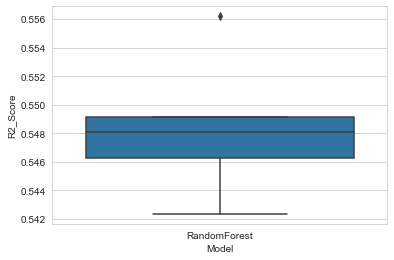

In [38]:
## V2
scores = evaluateModels(models,targets,X2,y2)
sns.boxplot(x="variable", y="value", data=pd.melt(scores))
plt.xlabel("Model")
plt.ylabel("R2_Score")

Text(0, 0.5, 'R2_Score')

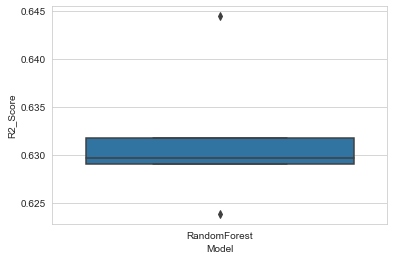

In [43]:
## V3
scores = evaluateModels(models,targets,X2.drop(columns=['length_description']),y2)
sns.boxplot(x="variable", y="value", data=pd.melt(scores))
plt.xlabel("Model")
plt.ylabel("R2_Score")

## Hyperparameter tuning
In order to improve the performances of the selected models we used the GridSearchCV that performs a Cross Validation over all the combinations of a given set of hyperparameters. Since we had enough data, we used the hold out technique, so we considered 80% for the train data and the remaining 20% for the testing the models. 

## Results
The results of the hyperparameters tuning can be seen in Table ##. Apparently they all outperformed their naive solutions and \[brodo\] 

In [45]:
def doGridSearch(model,model_name,hyperparams,X,y):
    gs = GridSearchCV(estimator=model,  
                         param_grid=hyperparams,
                         scoring='r2',
                         cv=4,
                         n_jobs=-1,
                         verbose=True)

    gs.fit(X, y)
    return gs

In [46]:
hyperparams_RF = {
    "n_estimators": [500],
    #"criterion": ["mse", "mae"],
    "max_features": ["auto", "sqrt", "log2"],
    "random_state": [42],# always use the samet random seed
    "n_jobs": [-1],# for parallelization
    "verbose" : True
}

In [48]:
gs = doGridSearch(RandomForestRegressor(), "RandomForestRegressor",hyperparams_RF,X2.drop(columns=['length_description']),y2)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  5.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.1min finished


In [49]:
print(f"Best params:\t{gs.best_params_}")
print(f"Best score:\t{gs.best_score_}")

Best params:	{'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
Best score:	0.627585358464138


In [52]:
y_pred = gs.predict(X_final_eval.drop(columns=['length_description']))

## Deploy

In [26]:
y_pred = gs.predict(X_final_eval)

In [53]:
def get_csv(ids, y):
    pd.DataFrame(dict(Id = ids,Predicted = y)).to_csv("submission2.csv",sep=",",index=False)

In [54]:
get_csv(list(X_eval.index),y_pred)

## Deploy history

### Submission 1 : 0.756 | 2021-01-11 16:24:05.639162 	
* Preprocessing: hash <br />
* Model : Random Forest <br />
* Hyperparams: {'max_features': 'sqrt', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42} <br />
* features : country,province,region_1, variety, winery, length_description <br />

### Submission 2 : 0.807 | 2021-01-12 08:14:14.977122	
* Preprocessing: hash <br />
* Model : Random Forest <br />
* Hyperparams: {'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
* features : country,province,region_1, variety, winery, designation <br />

## //Test